

```

```

Importing librarys

In [ ]:

# Importing required libraries
from torchvision import datasets, transforms
# PyTorch can extract datasets from GitHub
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Creating the model**- we use 2 conv layes first one with 32 filters to extract simple fetures ignoring negative pixels using relu(detecting) and shrinking the imege withe max pool (inhancing the filter) the second layer does the same but goes deeper withe 64 filters.
using dropout to prevent overfitting.
and 2 fully connected layers.

In [ ]:
# Defining the CNN model
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        # 1 channel as input (grayscale) using 32 filters applied with 3x3 kernel
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # ReLU to detect and reduce negative pixels
        self.relu1 = nn.ReLU()
        # Max pooling cuts the size by half and enhances the filters
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)



        # Flattening the image to one-dimensional for the fully connected layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.relu4 = nn.ReLU()
        # Dropout prevents the use of less useful neurons
        self.dropout1 = nn.Dropout(0.6)

        self.fc2 = nn.Linear(256, 128)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.6)

        # Output layer
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout1(self.relu4(self.fc1(x)))
        x = self.dropout2(self.relu5(self.fc2(x)))
        x = self.fc3(x)
        return x

Data Augmentation and data loader (downloading from github)

In [ ]:
# Data Augmentation
transform = transforms.Compose([

    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Splitting into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Printing dataset sizes
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


Number of training samples: 48000
Number of validation samples: 12000
Number of test samples: 10000


In [ ]:
# Initialize the model
model = FashionMNISTModel()

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # The loss function used
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
learning_rates = []



In [ ]:
# Training loop
epochs = 15
train_losses = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
epochs_without_improvement = 0
early_stopping_patience = 7

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = loss_fn(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()  # Accumulate loss

    # Validation step
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save best model state here
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered")
            break

    # Update scheduler
    scheduler.step(val_loss)
    learning_rates.append(scheduler.get_last_lr()[0])

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {running_loss / len(train_loader):.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")



Epoch 1/15, Training Loss: 0.8141, Validation Loss: 0.4390, Validation Accuracy: 84.30%
Epoch 2/15, Training Loss: 0.5230, Validation Loss: 0.3568, Validation Accuracy: 87.43%
Epoch 3/15, Training Loss: 0.4512, Validation Loss: 0.3432, Validation Accuracy: 87.27%
Epoch 4/15, Training Loss: 0.4124, Validation Loss: 0.3160, Validation Accuracy: 89.13%
Epoch 5/15, Training Loss: 0.3902, Validation Loss: 0.2926, Validation Accuracy: 89.50%
Epoch 6/15, Training Loss: 0.3681, Validation Loss: 0.2663, Validation Accuracy: 90.14%
Epoch 7/15, Training Loss: 0.3491, Validation Loss: 0.2879, Validation Accuracy: 89.63%
Epoch 8/15, Training Loss: 0.3379, Validation Loss: 0.2565, Validation Accuracy: 90.88%
Epoch 9/15, Training Loss: 0.3259, Validation Loss: 0.2588, Validation Accuracy: 90.42%
Epoch 10/15, Training Loss: 0.3095, Validation Loss: 0.2495, Validation Accuracy: 91.33%
Epoch 11/15, Training Loss: 0.2972, Validation Loss: 0.2301, Validation Accuracy: 91.88%
Epoch 12/15, Training Loss: 0.

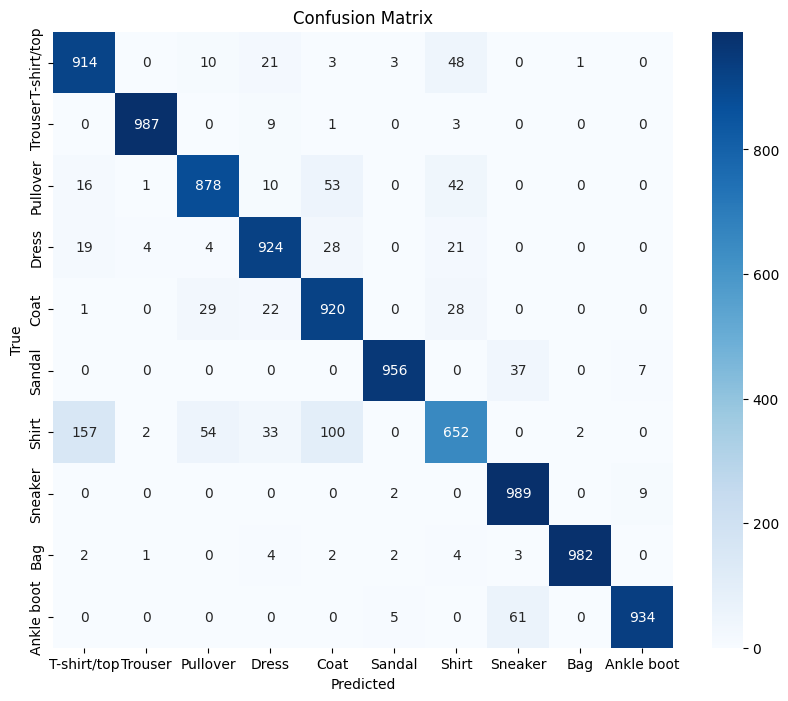

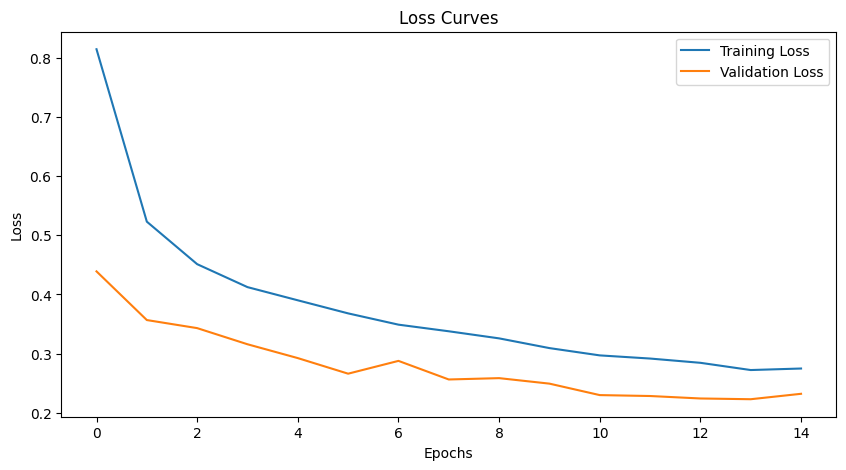

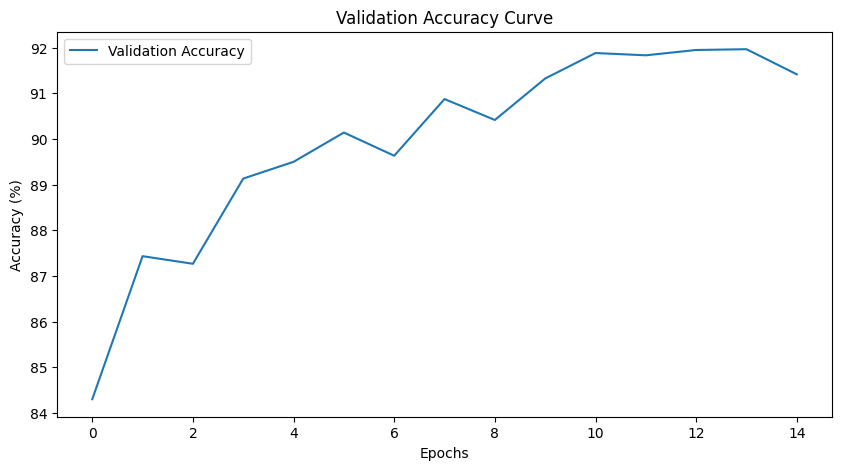

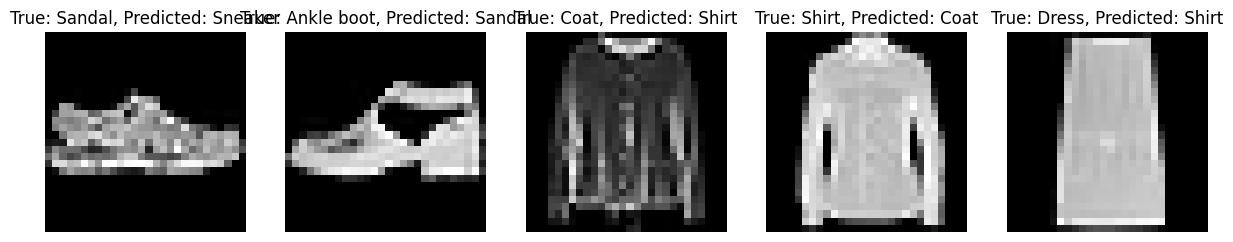

In [ ]:
# Evaluate the model on test data
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Loss and Accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Validation Accuracy Curve")
plt.show()

misclassified_indices = np.where(np.array(y_true) != np.array(y_pred))[0]
num_misclassified_to_show = 5  # Adjust as needed

fig, axes = plt.subplots(1, num_misclassified_to_show, figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:num_misclassified_to_show]):
    image, true_label = test_dataset[index]
    predicted_label = y_pred[index]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"True: {test_dataset.classes[true_label]}, Predicted: {test_dataset.classes[predicted_label]}")
    axes[i].axis('off')
plt.show()

In [ ]:
# Function to visualize filters and feature maps
def visualize_layer_filters(layer, layer_name):
    filters = layer.weight.data.cpu().numpy()
    num_filters = min(filters.shape[0], 10)  # Show up to 10 filters
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 15))
    for i, ax in enumerate(axes):
        if i < num_filters:
            ax.imshow(filters[i, 0], cmap='gray')  # Visualize the first channel
            ax.axis('off')
            ax.set_title(f'Filter {i + 1}')
    plt.suptitle(f'Filters of {layer_name}')
    plt.show()

def visualize_layer_feature_maps(model, layer, image, layer_name):
    model.eval()
    with torch.no_grad():
        feature_maps = layer(image)
    feature_maps = feature_maps.squeeze().cpu().numpy()
    num_feature_maps = min(feature_maps.shape[0], 10)  # Show up to 10 feature maps
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(15, 15))
    for i, ax in enumerate(axes):
        if i < num_feature_maps:
            ax.imshow(feature_maps[i], cmap='viridis')  # Visualize feature maps
            ax.axis('off')
            ax.set_title(f'Feature Map {i + 1}')
    plt.suptitle(f'Feature Maps of {layer_name}')
    plt.show()


Visualizing filters of conv1...


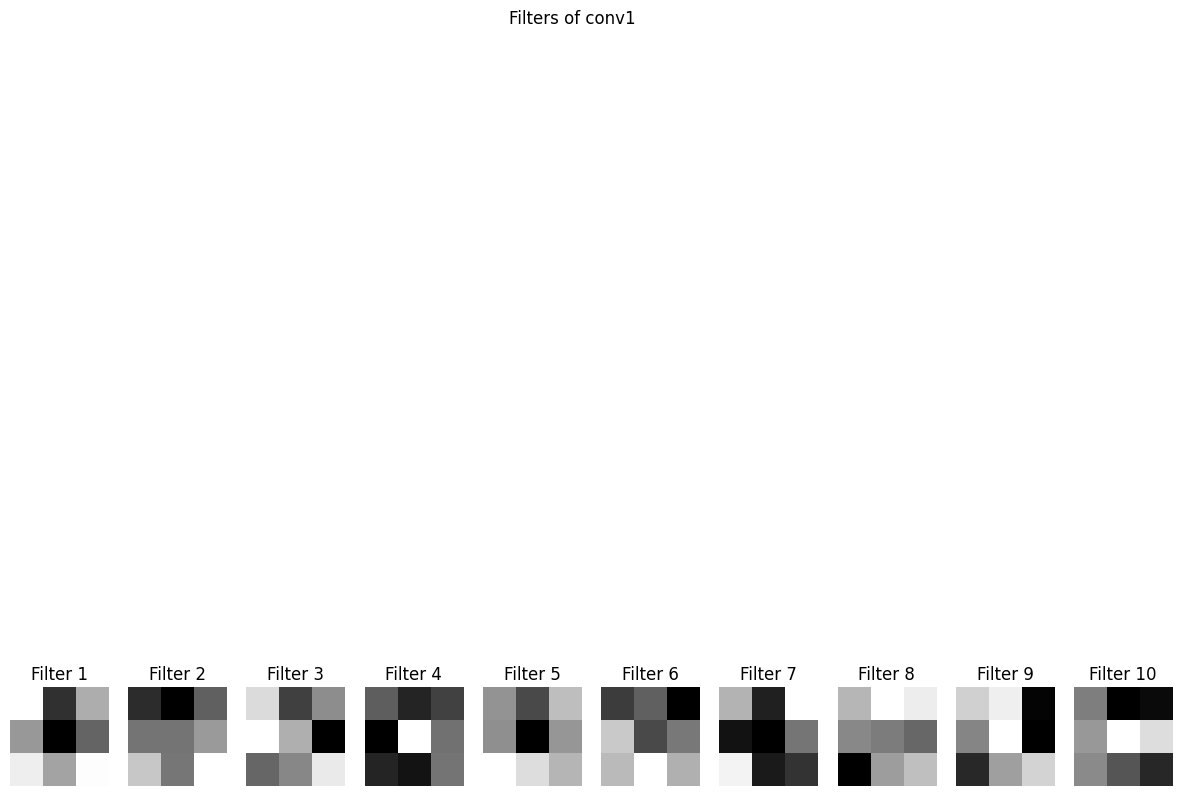

Visualizing feature maps of conv1...


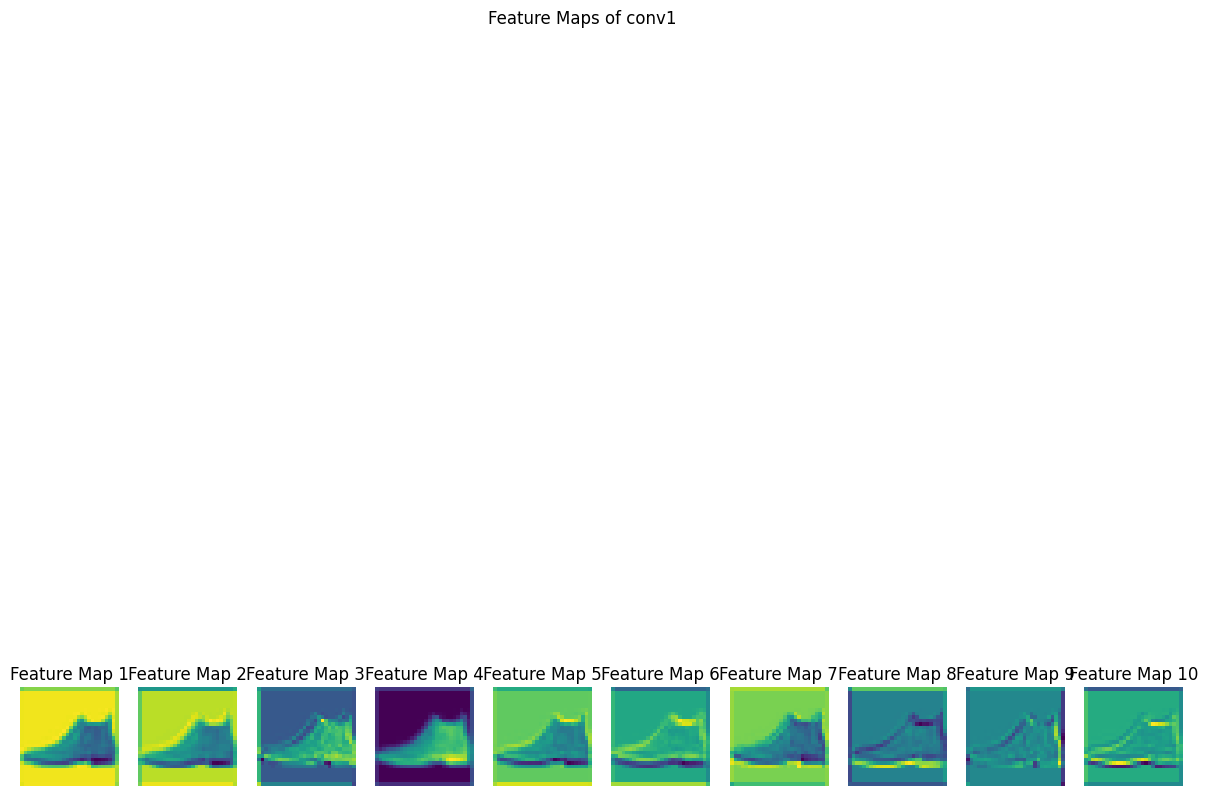

Visualizing feature maps of conv2...


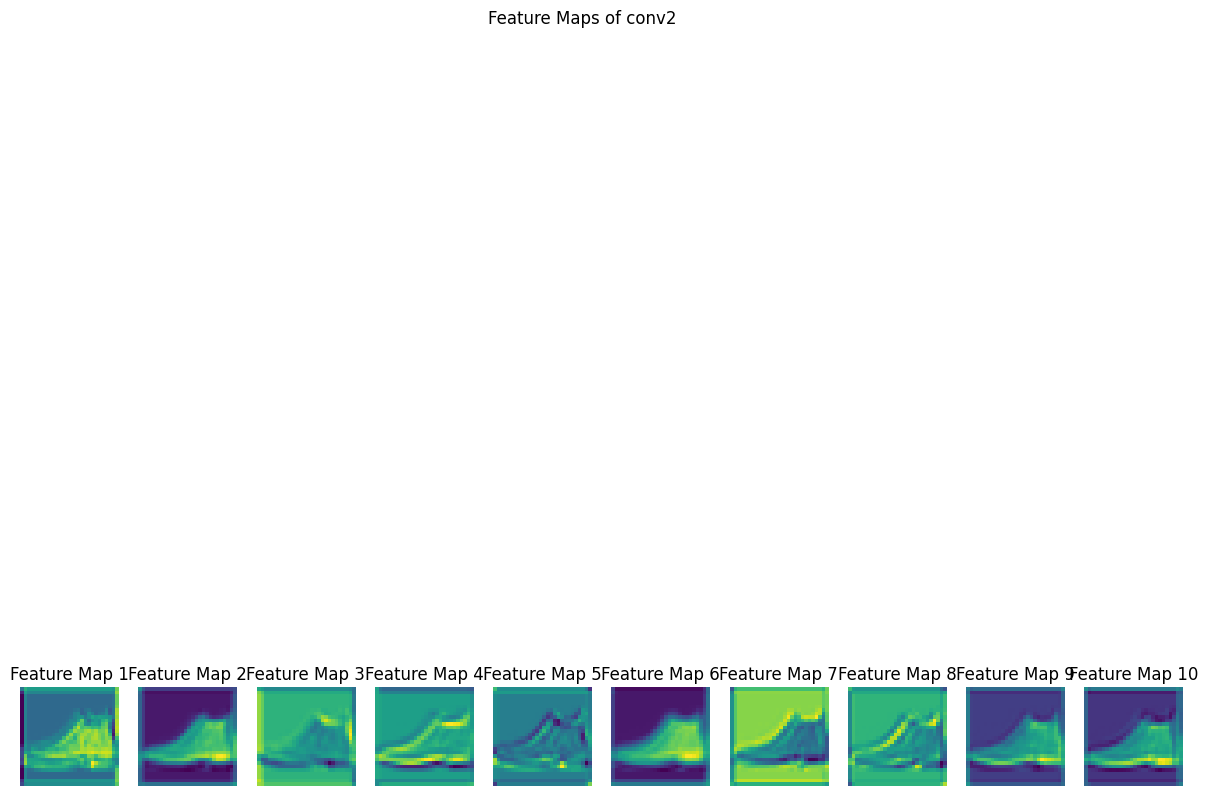

Model does not have a conv3 layer.


In [ ]:
# Visualizing filters of conv1
print("Visualizing filters of conv1...")
visualize_layer_filters(model.conv1, 'conv1')

# Selecting one sample image from the test set for visualization
sample_image, _ = test_dataset[0]
sample_image = sample_image.unsqueeze(0)  # Add batch dimension

# Visualizing feature maps of conv1
print("Visualizing feature maps of conv1...")
feature_maps_conv1 = model.conv1(sample_image)
visualize_layer_feature_maps(model, model.conv1, sample_image, 'conv1')

# Visualizing feature maps of conv2
print("Visualizing feature maps of conv2...")
feature_maps_conv2 = model.conv2(feature_maps_conv1)
visualize_layer_feature_maps(model, model.conv2, feature_maps_conv1, 'conv2')

# Visualizing feature maps of conv3 (third-level visualization)
if hasattr(model, 'conv3'):  # Check if conv3 exists
    print("Visualizing feature maps of conv3...")
    feature_maps_conv3 = model.conv3(feature_maps_conv2)
    visualize_layer_feature_maps(model, model.conv3, feature_maps_conv2, 'conv3')
else:
    print("Model does not have a conv3 layer.")



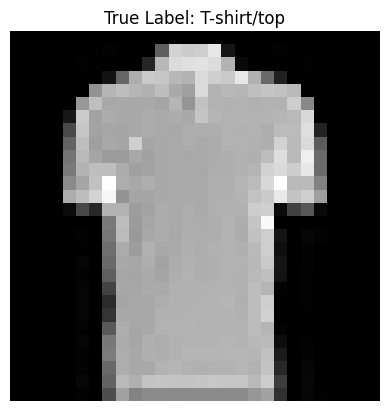

T-shirt/top: 0.9385
Trouser: 0.0000
Pullover: 0.0009
Dress: 0.0001
Coat: 0.0000
Sandal: 0.0000
Shirt: 0.0604
Sneaker: 0.0000
Bag: 0.0000
Ankle boot: 0.0000


In [ ]:


# Get a random image and its true label from the test dataset
image, label = test_dataset[np.random.randint(len(test_dataset))]

# Make a prediction using the model
model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Add batch dimension
    predicted_probs = torch.softmax(output, dim=1).squeeze().numpy()

# Display the image
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"True Label: {test_dataset.classes[label]}")
plt.axis('off')
plt.show()

# Display predicted probabilities
for i, prob in enumerate(predicted_probs):
    print(f"{test_dataset.classes[i]}: {prob:.4f}")

# ***my conclusions:***
"My main problem was the runtime of the code. Initially, when starting with a simple model with only two layers and no augmentations, I reached a high accuracy rate of 92%. However, after analyzing the loss and validation curves, I realized that the model had significant overfitting.

I then added more layers and introduced more augmentations while also changing the batch sizes and adjusting the number of filters at each layer. From this, I concluded that a lot of augmentation is needed along with the addition of more layers.

The issue was that with all these changes, the starting loss was extremely high, so I had to train for many more epochs. This put a strain on my computer's resources, and as a result, I had to settle for a worse result than what was theoretically possible."

# **Report**

**Dataset**-


*  FashionMNIST: The dataset consists of 70,000 grayscale images across 10 classes, where each image has a size of 28x28 pixels.


*   Training Set: 80% of the data (56,000 samples).

*  Validation Set: 20% of the training data (14,000 samples).
*   Test Set: 10,000 samples.


# *Model Architecture*

The CNN architecture includes three convolutional

Conv1: 32 filters, kernel size 3x3, followed by

BatchNorm, ReLU, and MaxPool.

Conv2: 64 filters, kernel size 3x3, followed by BatchNorm, ReLU, and MaxPool.

Conv3 (newly added): 128 filters, kernel size 3x3, followed by BatchNorm, ReLU, and MaxPool.

Fully Connected Layers:

FC1: 256 neurons with ReLU and Dropout.

FC2: 128 neurons with ReLU and Dropout.

Output: 10 neurons (one for each class).










# **Data Augmentation**
To improve generalization and enhance the dataset

variability, the following augmentations were applied:


*   Random Horizontal Flip

*   Random Rotation: Up to 30 degrees.
*   Random Crop: Added padding of 4 pixels before cropping.


*   Color Jitter: Adjusted brightness, contrast, and saturation.

These transformations significantly increased the model's ability to generalize to unseen data.


# ***training***
**Optimizer**: Adam optimizer with a learning rate of 0.
001 and weight decay of 0.0001.

**Scheduler**: ReduceLROnPlateau to dynamically reduce the learning rate based on validation loss.

**Loss Function**: CrossEntropyLoss.

**Batch Size**: 64.

**Number of Epochs**: 15.

This project successfully improved the CNN's performance on the FashionMNIST dataset to exceed the target validation accuracy of 92%.

 The following were key to achieving this result:

Adding a third convolutional layer for more feature extraction.

Applying extensive data augmentation to enhance generalization.

Using a learning rate scheduler to dynamically adjust learning rates.

# **Improvment**
implemanting more layers or augmentations requires more gpu space witche my copmputer did not like.
the model could potentialy reche accuracy of 99% with more elements.

*   addition of layers.
*   addition of Data Augmentation.


*   Ensemble Models: Combine predictions from multiple
 trained models to improve robustness and accuracy.






# ***Work procces***

Initial Model-
Two convolutional layers (conv1, conv2) followed by two fully connected layers.

MaxPooling after each convolutional layer.

Used ReLU activation and Dropout in the fully connected layers.

Added Third Convolutional Layer:
Increased neurons in fc1 to 256 and in fc2 to 128 for better feature representation.

Added Random Crop with padding and Color Jitter to enhance input variability.

Retained existing augmentations like Random Horizontal Flip and Rotation.

this changes reduced overfitting and improved my acuracy by about 5% (could be more if i added more layers).


